In [ ]:
import numpy as np
import scipy.optimize
import sklearn

implementing the following function

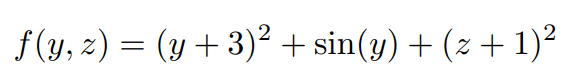

In [16]:
def pos_sin(dim_2_arr):
    y = dim_2_arr[0]
    z = dim_2_arr[1]
    return pow((y + 3), 2) + np.sin(y) + pow((z+1), 2)

In [ ]:
# define parameters to put insie the function
params = np.array([0,0], dtype=np.int16)

# x: estimated position of the minimum
# f: is the objective value at the minimum
# d: additional information
# d['funcalls']: number of times 'func' was called

# apporx_grad = true: The gradiant is approximately numerically
x, f, d = scipy.optimize.fmin_l_bfgs_b(func=pos_sin, x0=params, approx_grad=True)

print(f'estimated position "x"\t->\tx[0]: {x[0]}\t x[1]: {x[1]}')
print(f'objective value "f": {f}')
print(f"d['funcalls']: {d['funcalls']}")

estimated position "x"	->	x[0]: -2.577471382130981	 x[1]: -0.9999992747814318
objective value "f": -0.3561430123647567
d['funcalls']: 21


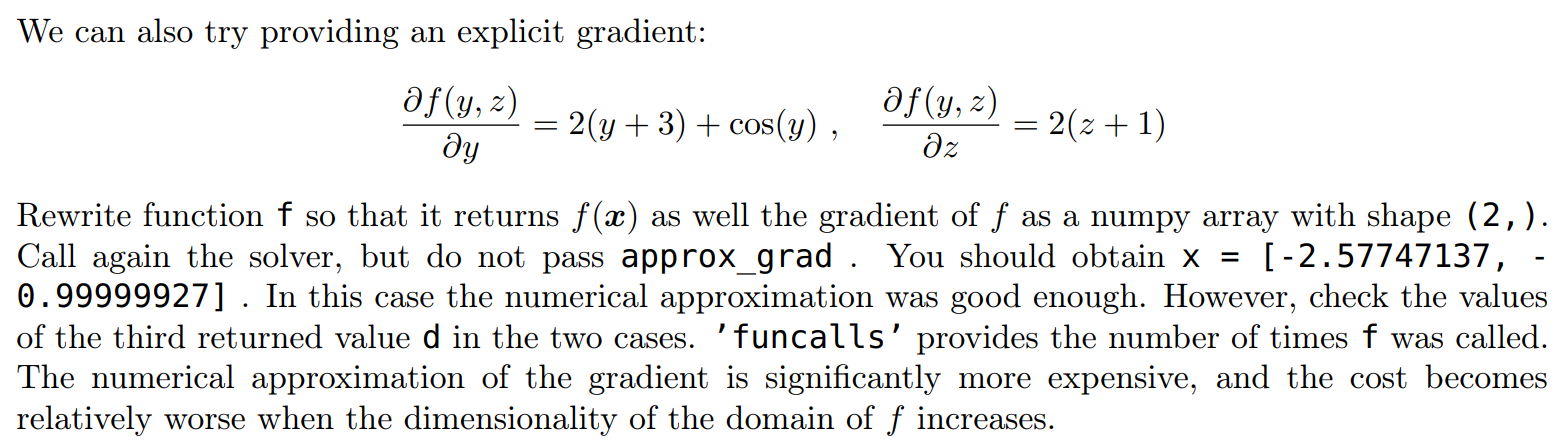

In [18]:
def pos_sin_grad(dim_2_arr):
    y = dim_2_arr[0]
    z = dim_2_arr[1]
    
    # compute gradiant
    df_dy = 2*(y+3) + np.cos(y)
    df_dz = 2*(z+1)
    
    res_fn = pow((y + 3), 2) + np.sin(y) + pow((z + 1), 2)
    res_grad =  np.array([df_dy, df_dz], dtype=np.float64)
    
    return res_fn, res_grad

In [19]:
#calling the solver again

params = np.array([0,0], dtype=np.int16)

x, f, d = scipy.optimize.fmin_l_bfgs_b(func=pos_sin_grad, x0=params)

print(f'estimated position "x"\t->\tx[0]: {x[0]}\t x[1]: {x[1]}')
print(f'objective value "f": {f}')
print(f"d['funcalls']: {d['funcalls']}")

estimated position "x"	->	x[0]: -2.577471374036827	 x[1]: -0.999999269397354
objective value "f": -0.3561430123647611
d['funcalls']: 7


Without numerical approximation (approx_grad = True) the computation of the gradient is expensive. Indeed in the first case(with approx_grad) the function is called 21 times, in the second case (no approx_grad) the function is called just 7 times.

### Binary Logistic Regression

We can now turn our attention to Logistic Regression. In this section we will implement the binary
version of the logistic regression to discriminate between iris virginica and iris versicolor. We will ignore
iris setosa. We will represent labels with 1 (iris versicolor) and 0 (iris virginica).

In [29]:
import sklearn.datasets


def load_iris_binary():
    D = sklearn.datasets.load_iris()['data'].T
    L = sklearn.datasets.load_iris()['target']
    D = D[:, L != 0]    # removing setosa from D
    L = L[L!=0]         # removing setosa from L
    L[L==2] = 0         # assigning label 0 to virginica
    return D, L

In [30]:
def split_db_2to1(D, L, seed=0):
    nTrain = int(D.shape[1]*2.0/3.0)
    np.random.seed(seed)
    idx = np.random.permutation(D.shape[1])
    idxTrain = idx[0:nTrain]
    idxTest = idx[nTrain:]
    DTR = D[:, idxTrain]
    DTE = D[:, idxTest]
    LTR = L[idxTrain]
    LTE = L[idxTest]
    return (DTR, LTR), (DTE, LTE)

In [31]:
D, L = load_iris_binary()
(DTR, LTR), (DVAL, LVAL) = split_db_2to1(D, L)

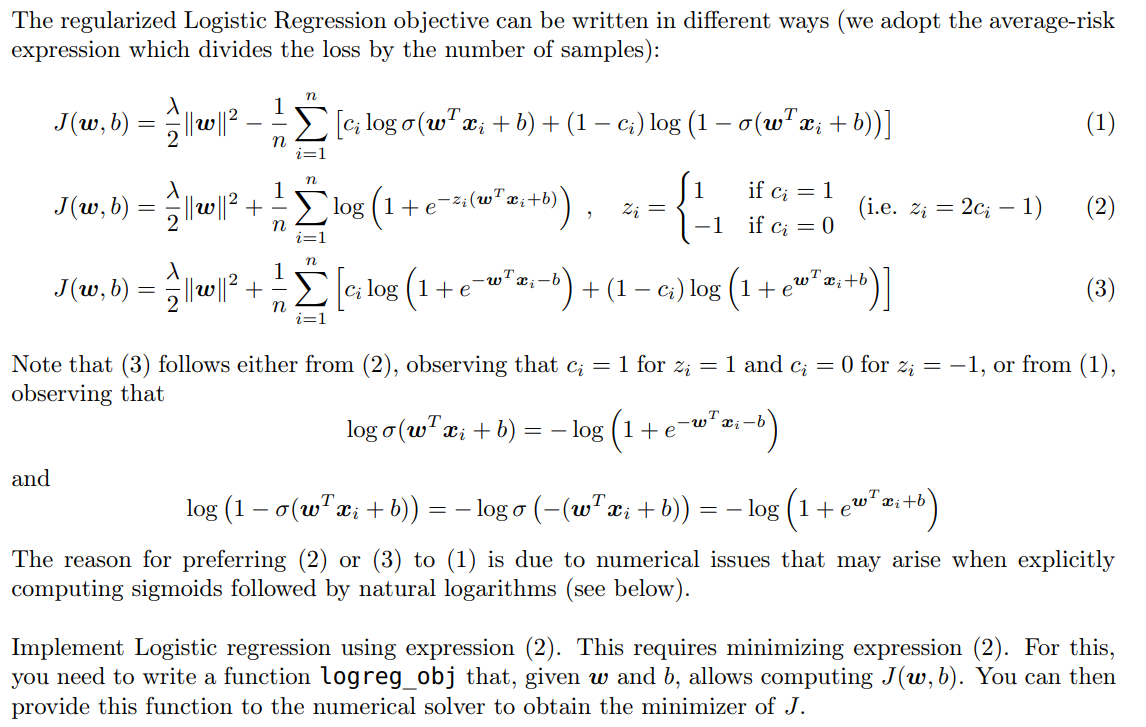